In [21]:
import sys
sys.path.insert(0,'..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

import numpy as np
from ensemble import run_ensemble, run_prediction
from util import read_data_in_dense_matrix, eval_prediction, clip_prediction, store_dense_matrix_to_submission
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Metadata for single prediction models
predictions = [
    {
        'method': 'DLE',
        'params': {
            'reg': 0.0015,
            'dim_embed': 3,
            'prior_reg': 0
        }
    },
    {
        'method': 'DLE',
        'params': {
            'reg': 0.0015,
            'dim_embed': 5,
            'prior_reg': 0
        }
    },
    {
        'method': 'DLE',
        'params': {
            'reg': 0.0015,
            'dim_embed': 7,
            'prior_reg': 0
        }
    },
    {
        'method': 'DLC',
        'params': {
            'reg': 0.0006625,
            'dim_embed': 8,
        }
    },
    {
        'method': 'DLC',
        'params': {
            'reg': 0.0006625,
            'dim_embed': 10,
        }
    },
    {
        'method': 'SVDPP',
        'params': {
            'first_reg': 0.001,
            'second_reg': 0.0015,
            'dim_embed': 14,
            'iters': 3000,
        }
    },
    {
        'method': 'ALS',
        'params': {
            'k': 1,
            'reg': 0.9,
        }
    },
    {
        'method': 'ALS',
        'params': {
            'k': 2,
            'reg': 0.9,
        }
    },
    {
        'method': 'ALS',
        'params': {
            'k': 3,
            'reg': 0.9,
        }
    },
    {
        'method': 'ALS',
        'params': {
            'k': 4,
            'reg': 0.9,
        }
    },
    {
        'method': 'ALS',
        'params': {
            'k': 5,
            'reg': 0.9,
        }
    },
    {
        'method': 'Nuclear',
        'params': {
            'best_iter': 183,
            'reg': 3.5,
        }
    },
    {
        'method': 'SVP',
        'params': {
            'best_iter': 206,
            'rank': 3,
        }
    },
    {
        'method': 'DMF',
        'params': {
            'reg': 15,
            'dim_embed': 13,
        }
    },
]

In [23]:
# Metadata for ensembles
ensembles = [
    {
        'method': 'equal_mean',
        'params':{

        }
    },
    # Use least square or ridge, which should be better and faster than GD
    # {
    #     'method': 'linear_gradient_descent',
    #     'params':{
    #         'reg': 0.2,
    #         'lr': 0.1,
    #     }
    # },
    {
        'method': 'linear_least_square',
        'params':{

        }
    },
    {
        'method': 'ridge',
        'params':{
            'alpha': 400.0,
        }
    },
    # {
    #     'method': 'decision_tree',
    #     'params':{
    #         'max_depth': 7,
    #     }
    # },
    # {
    #     'method': 'xgboost',
    #     'params':{
    #     }
    # },
    # {
    #     'method': 'gbdt',
    #     'params': {
    #         'max_depth': 6
    #     }
    # }
]

In [24]:
metadata = {
    'predictions' : predictions,
    'ensembles': ensembles,
    'random_seed': 0,
    'test_size': 0.1,
    'ensemble_test_size': 0.05,
    'pre_clip': False
}

In [25]:
data_dir = '../../data/'
result_file_name = '20220710'

In [26]:
result_path = os.path.join(data_dir, 'results', result_file_name+'.pkl')

# Create results dir if not exists
if not os.path.exists(os.path.dirname(result_path)):
    os.mkdir(os.path.dirname(result_path))

# Read result file
old_result = None
if os.path.exists(result_path):
    with open(result_path, 'rb') as f:
        old_result = pickle.load(f)
    # Check metadata. If not consistent then store results to a new file.
    if metadata['test_size'] != old_result['test_size'] or metadata['random_seed'] != old_result['random_seed']:
        print(metadata)
        raise ValueError('Found {}, but metadata (test_size/random_seed) not consistent. Please modify metadata, or use another filename.'.format(result_path))

In [27]:
def find_prediction_result(pred_dict, old_result):
    if old_result is None:
        return None
    for pred_dict_old in old_result['predictions']:
        if pred_dict['method'] == pred_dict_old['method'] and pred_dict['params'] == pred_dict_old['params']:
            return pred_dict_old['result']
    
    return None

# Run each prediction model
for pred_dict in predictions:
    result = find_prediction_result(pred_dict, old_result)
    assert result is not None, "Unknown result wanted."
    pred_dict['result'] = result

In [28]:
pred_list = []
for pred_dict in predictions:
    pred_list.append(pred_dict['result'].reshape(1,-1))

pred = np.concatenate(pred_list, axis=0)
pred.shape

(14, 10000000)

In [30]:
corr = np.corrcoef(pred)


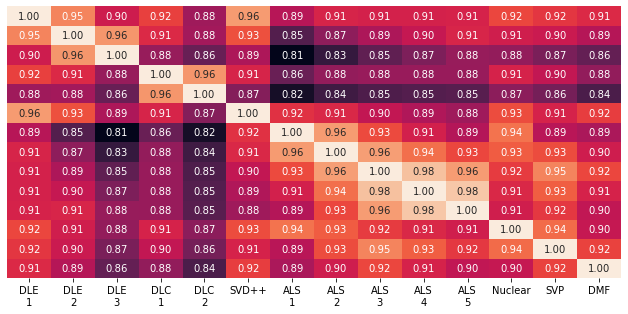

In [49]:
def construct_ticks(method_and_repeats_list):
    ticks = []
    for name, repeats in method_and_repeats_list:
        if repeats > 1:
            ticks += [f"{name}\n{i+1}" for i in range(repeats)]
        else:
            ticks.append(name)
    return ticks

plt.figure(figsize=(11,5))
sns.heatmap(corr, annot=True, fmt='.2f', cbar=False)
plt.yticks([], [])
names_and_repeats = [
    ("DLE", 3), ("DLC", 2), ("SVD++", 1), ("ALS", 5), ("Nuclear", 1), ("SVP", 1), ("DMF", 1)
    ]
ticks = construct_ticks(names_and_repeats)
plt.xticks(np.arange(len(ticks))+0.5, ticks)
plt.savefig("../imgs/corr.pdf")
plt.show()